# NY Child and Dependent Care Credit

The NY CDCC is a percentage of the federal CDCC with one modification: the maximum allowable childcare expenses under federal rules are replaced with NY-specific maximums (still dependent on the number of children).

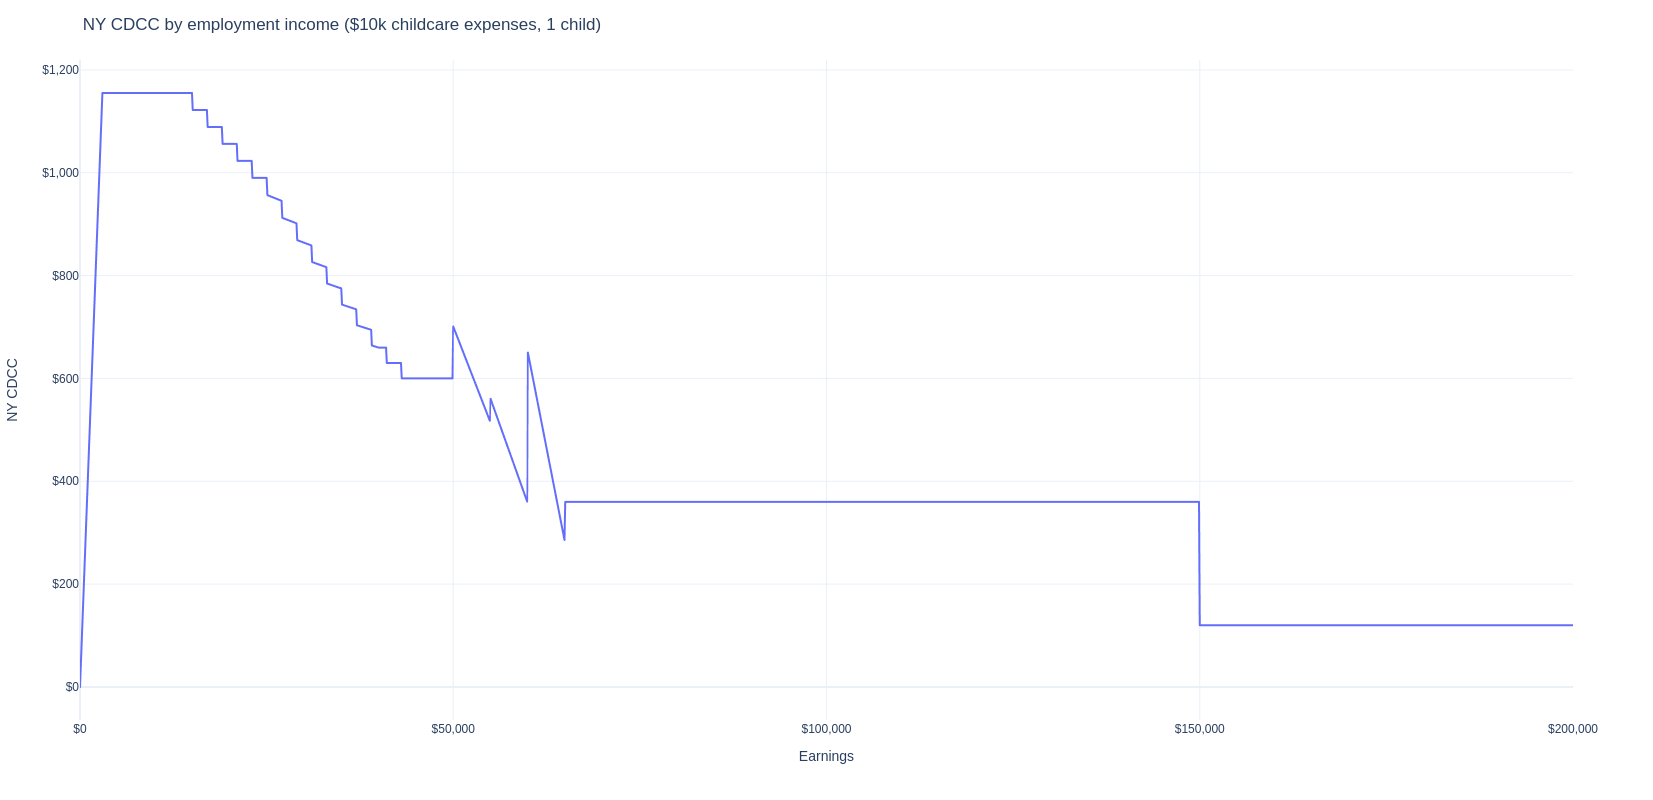

In [16]:
from policyengine_us import IndividualSim, Microsimulation
import plotly.express as px

sim = IndividualSim()
sim.add_person(name="parent", age=30)
sim.add_person(name="child", age=6)
sim.add_tax_unit(
    members=["parent", "child"], tax_unit_childcare_expenses=10_000
)
sim.add_household(members=["parent", "child"], state_code="NY")
sim.vary("employment_income")

px.line(
    y=sim.calc("ny_cdcc")[0],
    x=sim.calc("employment_income")[0],
).update_layout(
    yaxis_tickformat="$,.0f",
    xaxis_tickformat="$,.0f",
    height=800,
    width=800,
    xaxis_title="Earnings",
    yaxis_title="NY CDCC",
    title="NY CDCC by employment income ($10k childcare expenses, 1 child)",
    template="plotly_white",
)

The reason for the highly irregular shape of the credit is mostly due to NY legislative decisions. The percentage of the federal credit that defines the NY credit is as shown below. This is the same as the table on [the Form IT-216 instructions](https://www.tax.ny.gov/pdf/current_forms/it/it216i.pdf#page=8).

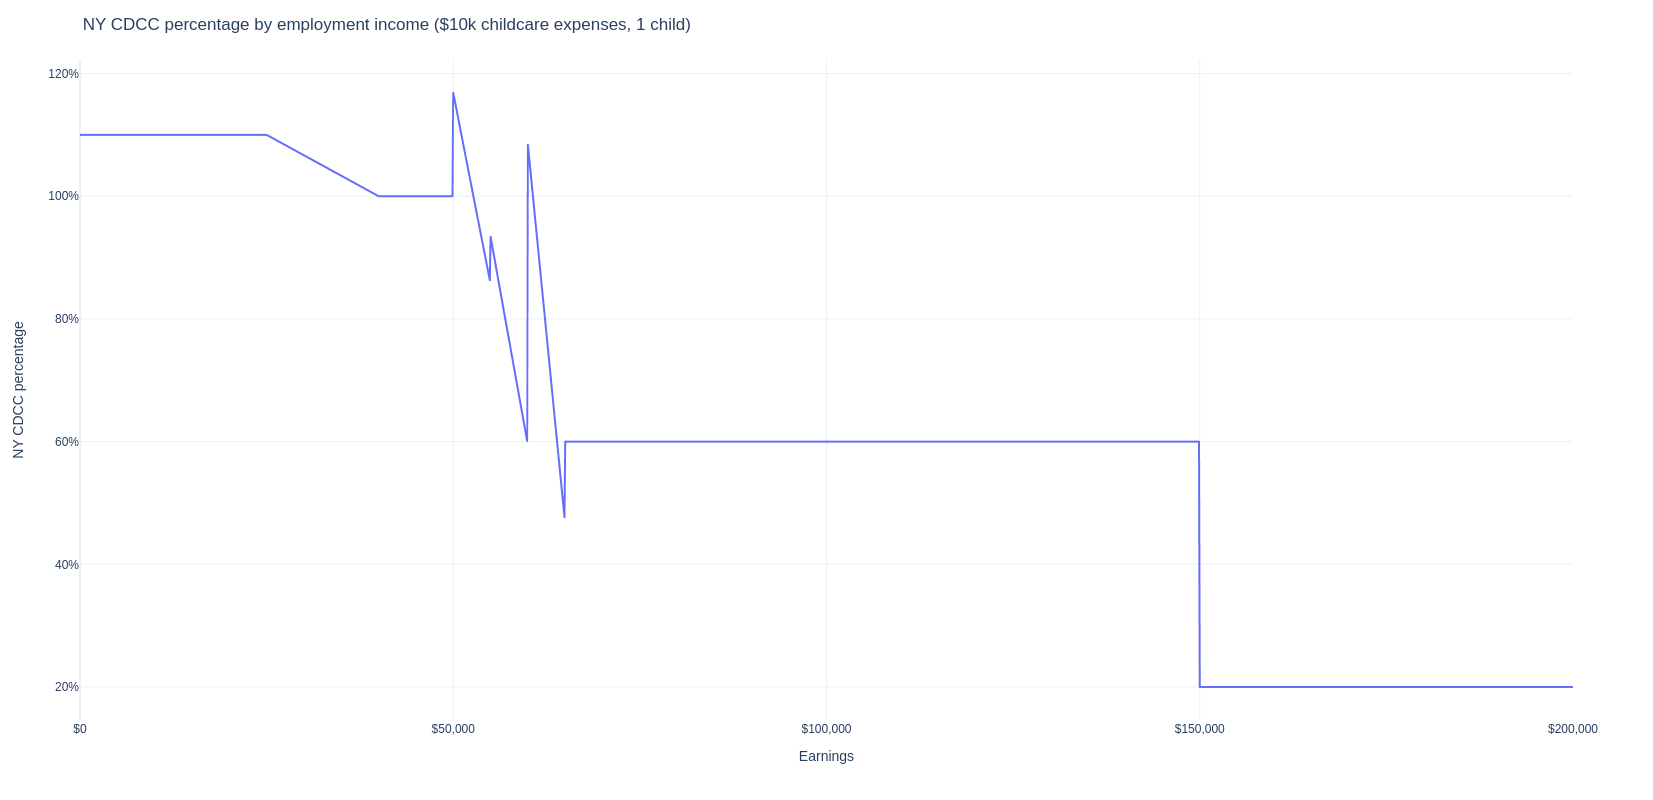

In [17]:
px.line(
    y=sim.calc("ny_cdcc_rate")[0],
    x=sim.calc("employment_income")[0],
).update_layout(
    yaxis_tickformat=".0%",
    xaxis_tickformat="$,.0f",
    height=800,
    width=800,
    xaxis_title="Earnings",
    yaxis_title="NY CDCC percentage",
    title="NY CDCC percentage by employment income ($10k childcare expenses, 1 child)",
    template="plotly_white",
)

Based on the 2020 CPS, the 2022 NY CDCC would have cost \$113 million.
It does not interact with other programs, so this is also the total value of the program.

In [5]:
from policyengine_us.model_api import *


def budgetary_impacts(
    variable: str, data_year: int = 2020, policy_year: int = 2022
) -> Tuple:
    """Calculates the budgetary impact of a variable for a given policy year.

    Args:
        variable (str): The variable to calculate the budgetary impact of.
        data_year (int): The year of the data to use.
        policy_year (int): The year of the policy to use.

    Returns:
        Tuple: A tuple of the total cost and budgetary impact of repealing the variable,
        respectively, in millions.
    """

    class ignore_reported(Reform):
        def apply(self):
            self.neutralize_variable("spm_unit_net_income_reported")

    class neutralize(Reform):
        def apply(self):
            self.neutralize_variable(variable)

    sim = Microsimulation(ignore_reported, year=data_year)
    sim_neutralized = Microsimulation(
        (ignore_reported, neutralize), year=data_year
    )
    program_value = sim.calc(variable, period=policy_year).sum()
    baseline_net_income = sim.calc(
        "spm_unit_net_income", period=policy_year
    ).sum()
    neutralized_net_income = sim_neutralized.calc(
        "spm_unit_net_income", period=policy_year
    ).sum()
    budgetary_impact = neutralized_net_income - baseline_net_income
    return round(program_value / 1e6), round(budgetary_impact / 1e6)


budgetary_impacts("ny_cdcc")